# Import des librairies

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os

from IPython.core.pylabtools import figsize
from pandas import Timestamp
from pandas.core.interchange.dataframe_protocol import DataFrame
from polars.datatypes.group import DATETIME_DTYPES

# Extraction du fichier CSV à partir du fichier .zip brut
Le fichier CSV ayant une taille de 383,7 Mo, il est impossible de le stocker sur Github. En effet, Github bloque l'upload des fichiers de plus de 100 Mo. Afin de pouvoir reproduire l'analyse des données et le traitement effectué dans ce Notebook, nous allons donc utiliser le fichier au format .zip tel que récupéré sur Kaggle.
Si une copie locale des données au format CSV existe, alors cette copie est utilisée. Sinon, le fichier CSV est extrait lors de la première exécution du Notebook.

In [31]:
if not os.path.exists("data/raw/btcusd_1-min_data.csv"):
    print("Fichier CSV inexistant, extraction à partir du fichier .zip ...")
    with zipfile.ZipFile("data/raw/btcusd_1-min_data_11_30_2025.zip","r") as zip_ref:
        zip_ref.extractall("data/raw/")
        print("Fichier CSV créé !")
else:
    print("Fichier CSV déjà existant, poursuite de l'exécution ...")


Fichier CSV déjà existant, poursuite de l'exécution ...


# Analyse préliminaire

Chargement des données CSV dans un DataFrame:

In [32]:
df_bitcoin_raw = pd.read_csv("data/raw/btcusd_1-min_data.csv")

In [33]:
df_bitcoin_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7317759 entries, 0 to 7317758
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 335.0 MB


In [34]:
length_df_raw = len(df_bitcoin_raw)
print(length_df_raw)

7317759


Nous obtenons donc un DataFrame comportant 7 317 759 lignes, avec 6 colonnes qui sont: `Timestamp`, `Open`, `High`, `Low`, `Close` et `Volume`
Toutes ces colonnes sont pour l'instant de `dtypes: float(64)`.

## Statistiques descriptives du DataFrame

In [35]:
df_bitcoin_raw.describe()

,Timestamp,Open,High,Low,Close,Volume
count,7.317759e+06,7.317759e+06,7.317759e+06,7.317759e+06,7.317759e+06,7.317759e+06
mean,1.544948e+09,2.124984e+04,2.125747e+04,2.124200e+04,2.124985e+04,5.128479e+00
std,1.267532e+08,2.992120e+04,2.992935e+04,2.991293e+04,2.992120e+04,2.206739e+01
min,1.325412e+09,3.800000e+00,3.800000e+00,3.800000e+00,3.800000e+00,0.000000e+00
25%,1.435178e+09,4.430000e+02,4.431400e+02,4.428800e+02,4.430000e+02,1.959880e-02
50%,1.544945e+09,7.280770e+03,7.285000e+03,7.276340e+03,7.280650e+03,4.481621e-01
75%,1.654711e+09,3.066300e+04,3.067300e+04,3.065317e+04,3.066301e+04,2.897836e+00
max,1.764547e+09,1.262020e+05,1.262720e+05,1.261580e+05,1.262020e+05,5.853852e+03


In [36]:
df_bitcoin_raw.dtypes

Timestamp    float64
Open         float64
High         float64
Low          float64
Close        float64
Volume       float64
dtype: object

## Identification des valeurs manquantes

In [37]:
print(df_bitcoin_raw.isna().sum())

Timestamp    0
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64


On peut observer qu'il n'y a aucune valeurs manquantes.

## Identifications des doublons
Il n'est pas pertinent d'étudier les doublons des colonnes numériques `Open`, `High`, `Low`, `Close` et `Volume`.
En effet, le Bitcoin peut très bien avoir eu le même prix ou volume plusieurs fois depuis que les données ont été collectées.
Nous allons cependant étudier la colonne `Timestamp`, représentant un instant T où les données ont été relevées.

In [38]:
print(df_bitcoin_raw["Timestamp"].iloc[0])


1325412060.0


On remarque que les valeurs contenues dans la colonne `Timestamp` sont au format Timestamp Unix, qui associe un nombre réel au temps mesuré depuis le 1er janvier 1970 à 00:00:00.
Ces valeurs sont donc supposées uniques (un instant T correspondant à un nombre réel unique), nous pouvons donc facilement vérifier l'existance de doublons.

In [39]:
unique_timestamps = df_bitcoin_raw["Timestamp"].nunique()
print(f"Longueur du DataFame et nombre de Timestamp différent équivalent ? {unique_timestamps == length_df_raw}")
print(f"Nombre de lignes doublons: {df_bitcoin_raw.duplicated().sum()}")

Longueur du DataFame et nombre de Timestamp différent équivalent ? True
Nombre de lignes doublons: 0


Le nombre de valeurs uniques de Timestamp étant égal au nombre de lignes dans le DataFrame et n'ayant pas de lignes en double, nous pouvons estimer qu'il n'existe pas de lignes dupliquées dans les données utilisées.

## Conversion de "Timestamp" (float64, unix epoch time) en DateTime
Afin de poursuivre l'analyse sans modifier le DataFrame de base, nous utiliserons désormais une copie.

In [40]:
df_bitcoin_modified = df_bitcoin_raw.copy()

La conversion du Timestamp en format lisible nous permet une meilleure analyse des données. Il est nécessaire de convertire ce Timestamp de `float` à `int`. Ce timestamp correspond au format Unix équivalent aux secondes, ce qui doit être passé en argument.

In [41]:
df_bitcoin_modified["Timestamp"] = pd.to_datetime(df_bitcoin_modified["Timestamp"].astype(int), unit="s")

In [42]:
df_bitcoin_modified

,Timestamp,Open,High,Low,Close,Volume
0,2012-01-01 10:01:00,4.58,4.58,4.58,4.58,0.000000
1,2012-01-01 10:02:00,4.58,4.58,4.58,4.58,0.000000
2,2012-01-01 10:03:00,4.58,4.58,4.58,4.58,0.000000
3,2012-01-01 10:04:00,4.58,4.58,4.58,4.58,0.000000
4,2012-01-01 10:05:00,4.58,4.58,4.58,4.58,0.000000
...,...,...,...,...,...,...
7317754,2025-11-30 23:55:00,90405.00,90452.00,90403.00,90452.00,0.531700
7317755,2025-11-30 23:56:00,90452.00,90481.00,90420.00,90420.00,0.055547
7317756,2025-11-30 23:57:00,90412.00,90458.00,90396.00,90435.00,0.301931
7317757,2025-11-30 23:58:00,90428.00,90428.00,90362.00,90362.00,4.591653


In [43]:
df_bitcoin_modified.dtypes

Timestamp    datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Volume              float64
dtype: object

## Analyse de l'existence de périodes manquantes
Les données issues de Timestamp étant désormais dans un format lisible et reconnaissable par Pandas, nous pouvons donc vérifier si des périodes de temps sont manquantes.

Pour cela, nous allons trier les dates dans un ordre ascendant (dans les cas où les lignes ne sont pas correctement "rangées"), puis nous pourrons récupérer les valeurs minimum et maximum afin de créer une `Serie` temporelle équivalente.

En comparant notre colonne `Timestamp` à cette série, nous pourrons identifier les périodes temporelles manquantes si elles existent.

In [44]:
serie_timestamp = df_bitcoin_modified['Timestamp'].sort_values(ascending=True)

In [45]:
first_timestamp = serie_timestamp.iloc[0]
last_timestamp = serie_timestamp.iloc[-1]
print(f"Première valeur Timestamp : {first_timestamp}")
print(f"Dernière valeur Timestamp : {last_timestamp}")

Première valeur Timestamp : 2012-01-01 10:01:00
Dernière valeur Timestamp : 2025-11-30 23:59:00


Créons maintenant la série temporelle permettant de vérifier les différences, en utilisant les valeurs trouvées.

In [46]:
serie_timestamp_difference = pd.Series(pd.date_range(start=first_timestamp, end=last_timestamp, freq='min'))
print(serie_timestamp_difference.head())

0   2012-01-01 10:01:00
1   2012-01-01 10:02:00
2   2012-01-01 10:03:00
3   2012-01-01 10:04:00
4   2012-01-01 10:05:00
dtype: datetime64[ns]


Vérifions désormais la différence.

In [47]:
missing_periods = serie_timestamp_difference[~serie_timestamp_difference.isin(serie_timestamp)]
if len(missing_periods) > 0:
    print(f"Il y a {len(missing_periods)} périodes manquantes au total")

    # Vérifions si ces périodes manquantes sont réunies en un seul 'bloc' ou si elles sont dispersées
    missing_sorted = missing_periods.sort_values(ascending=True) # Tri ascendant pour s'assurer de la cohérence

    # On sait que l'intervalle attendu correspond à 1 minute, puisque notre serie_timestamp_difference a été créé avec une
    # fréquence d'1 minute
    expected_interval = pd.Timedelta(minutes=1)

    # Si la différence est égale à 1 minute, les périodes manquantes sont dans le même 'bloc'
    differences = missing_sorted.diff()

    # On calcule le nombre de 'blocs' où l'intervalle ne correspond pas à la valeur attendue
    num_blocks = (differences != expected_interval).sum()
    print(f"Il y a {num_blocks} blocs de temps manquants")

    # Nous cherchons maintenant à identifier les débuts et fins des blocs de temps manquants
    block_starts = missing_sorted[differences != expected_interval].index
    for i, start_index in enumerate(block_starts):
        # On récupère le timestamp de début du bloc actuel
        start_timestamp = missing_sorted.loc[start_index]

        # On vérifie s'il y a un bloc suivant, `-1` car l'index débute à `0`
        if i < len(block_starts) - 1:
            next_start = block_starts[i + 1]
            # Le timestamp de fin est celui juste avant le début du prochain bloc
            end_index = missing_sorted.index[missing_sorted.index.get_loc(next_start) - 1]
            end_timestamp = missing_sorted.loc[end_index]
        else:
            # Pour le dernier bloc, la fin est la dernière période manquante
            end_timestamp = missing_sorted.iloc[-1]
            print(f"Bloc {i+1}: de {start_timestamp} à {end_timestamp}")
else:
    print("Aucune période manquante détectée")


Il y a 1160 périodes manquantes au total
Il y a 1 blocs de temps manquants
Bloc 1: de 2025-03-15 00:01:00 à 2025-03-15 19:20:00


Nous observons donc un bloc de 1160 minutes consécutives pendant lesquelles les données n'ont pas été relevées.

Cela peut s'expliquer par une panne de la plateforme d'échange de cryptomonnaies utilisée pour collecter les données ou un problème technique rencontré par l'outil utilisé pour collecter les données.

In [48]:
missing_pct = len(missing_periods) / unique_timestamps * 100
print(f"Ces périodes manquantes correspondent à {round(missing_pct, 5)}% des données totales")

Ces périodes manquantes correspondent à 0.01585% des données totales


L'existence de ces périodes manquantes sera importante plus tard, lorsque nous réaliserons des agrégations temporelles.

## Utilisation de Timestamp comme index
Afin de pouvoir analyser plus finement les données, nous utiliserons les valeurs de la colonne `Timestamp` comme index de notre DataFrame.

In [49]:
df_bitcoin_modified.set_index("Timestamp", inplace=True)

## Interpolation linéaire afin de combler les 1160 minutes manquantes
L'interpolation linéaire permet de remplir les valeurs manquantes à l'aide d'une fonction affine estimé à partir des données connues du DataFrame.

In [50]:
df_bitcoin_modified= df_bitcoin_modified.resample('1min').interpolate(method='linear')

Nous pouvons vérifier si les valeurs manquantes ont bien été comblées.

In [51]:
print(f"Nombre de lignes du DataFrame brut: {length_df_raw}")
print(f"Nombre de lignes du DataFrame après interpolation linéaire: {len(df_bitcoin_modified)}")
print(f"Différence enter les deux valeurs: {len(df_bitcoin_modified) - length_df_raw}")

Nombre de lignes du DataFrame brut: 7317759
Nombre de lignes du DataFrame après interpolation linéaire: 7318919
Différence enter les deux valeurs: 1160


Nous obtenons bien 1160 nouvelles lignes.

# Analyse univariée
## Analyse de la distribution
Nous allons dans un premier temps analyser la forme de la distribution des données.

Pour cela nous utiliserons une fonction retournant un DataFrame identifiant les valeurs `skew()` et `kurt()` pour chaque colonne de notre DataFrame.

In [52]:
from pandas import DataFrame

def identify_distribution_to_df(df: DataFrame) -> DataFrame:
    """
    Analyse les colonnes numériques d'un DataFrame et identifie leurs valeurs skew
    et kurt. Retourne les valeurs dans un nouveau DataFrame.\n
    skew: Asymétrie (0 = symétrique)\n
    kurt: Aplatissement (>3 = queues épaisses)
    :param df: DataFrame
    :type df: pandas.DataFrame
    :return: DataFrame contenant les noms des colonnes d'entrée, leurs valeurs
     skew et kurt.
    :rtype: tuple
    """
    distribution_list = []
    for series_name, series in df.select_dtypes(include=np.number).items():
        skew = series.skew()
        kurt = series.kurt()

        column_dict = {"Column": series_name, "skew": skew, "kurt": kurt}
        distribution_list.append(column_dict)

    df_stats = pd.DataFrame(distribution_list)

    return df_stats


In [53]:
df_bitcoin_stats = identify_distribution_to_df(df_bitcoin_modified)
df_bitcoin_stats

,Column,skew,kurt
0,Open,1.652967,1.886053
1,High,1.652651,1.884732
2,Low,1.653294,1.887415
3,Close,1.652959,1.886024
4,Volume,27.801996,2479.933778


Nous pouvons observer une forte asymétrie (valeur `skew`) pour chacune de nos colonnes, ainsi que la présence d'une queue à droite (valeur `skew` > 0) pour chaque colonne étudiée.

Nous pouvons observer la forme de la distribution à l'aide de Violin plots. Un échantillonnage aléatoire est utilisé afin de n'étudier que 100000 (valeur `sample_size`) points au lieu de plus de 7.3 millions, accélerant grandement l'affichage des visualisations.

Un `random_state` est défini à `42` pour la reproductibilité de l'échantillonnage.

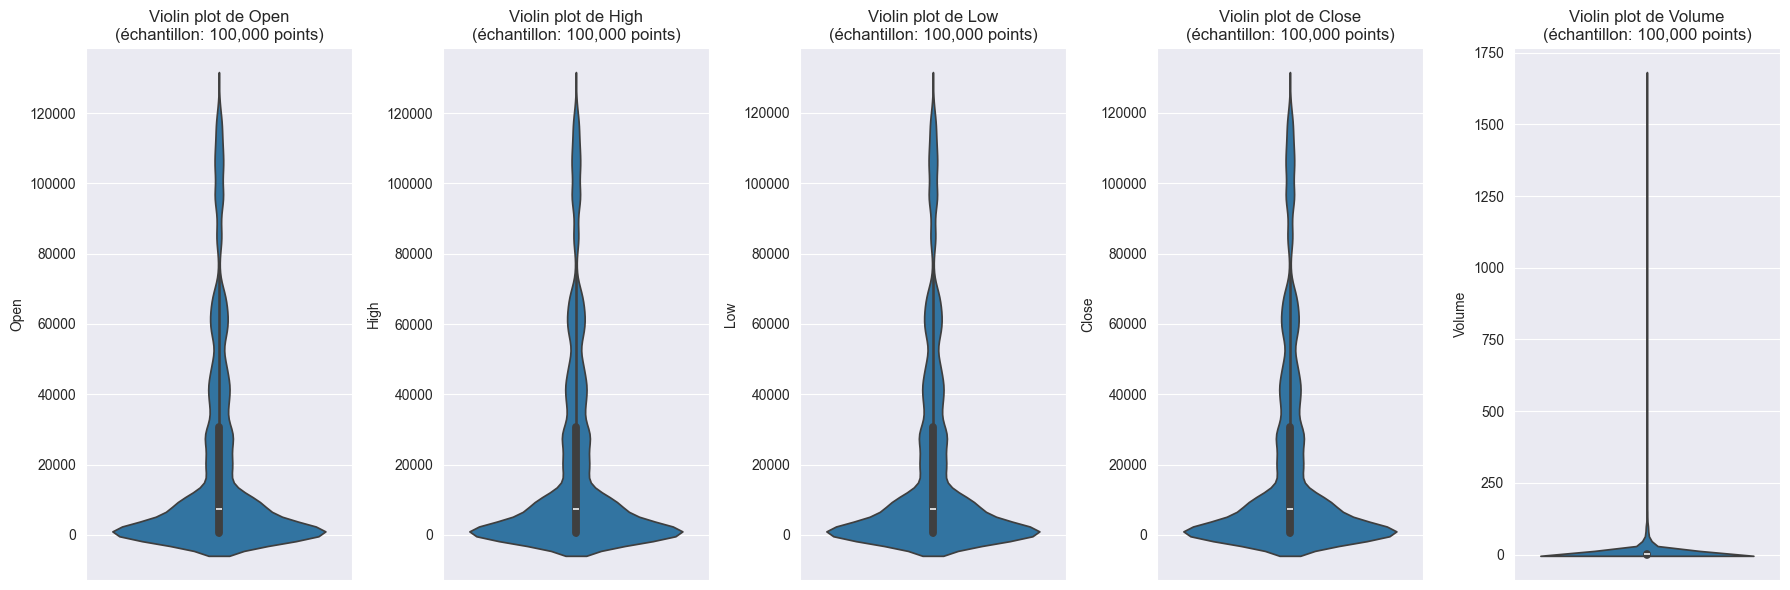

In [54]:
import seaborn as sns

sample_size = 100_000
df_sample_violins = df_bitcoin_modified.sample(n=sample_size, random_state=42)

fig, axes = plt.subplots(1, 5, figsize=(18, 6))

for i, col in enumerate(['Open', 'High', 'Low', 'Close', 'Volume']):
    sns.violinplot(y=df_sample_violins[col], ax=axes[i])
    axes[i].set_title(f'Violin plot de {col}\n(échantillon: {sample_size:,} points)')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()


## Calcul des Z-Scores
Afin d'identifier les outliers (valeurs aberrantes), nous allons calculer le Z-score correspondant à chaque valeur de notre dataset.

In [55]:
def calculate_z_scores(df: DataFrame) -> DataFrame:
    """
    Calcule les z-scores pour chaque colonne d'un DataFrame.
    Le z-score indique à combien d'écarts-types une valeur se situe de la moyenne.\n
    Formule: z = (x - moyenne) / écart-type\n
    Un z-score de 0 = valeur égale à la moyenne\n
    Un z-score de 2 = valeur à 2 écarts-types au-dessus de la moyenne
    Un z-score > 3 = outlier potentiel
    :param df: DataFrame contenant les données à utiliser
    :type df: pandas.DataFrame
    :return: DataFrame contenant les z-scores pour chaque colonne
    :rtype: pandas.DataFrame
    """
    z_score_list = []

    for series_name, series in df.items():
        z_scores = (df[series_name] - df[series_name].mean()) / df[series_name].std()
        z_score_list.append(z_scores)

    return pd.DataFrame(z_score_list)

In [56]:
df_z_score = calculate_z_scores(df_bitcoin_modified)
print(df_z_score.shape)

(5, 7318919)


La forme du DataFrame `df_z_score` ne correspond pas à la forme de notre DataFrame d'entrée

In [57]:
print(df_bitcoin_modified.shape)

(7318919, 5)


On transpose donc le DataFrame `df_z_score` afin de conserver les mêmes colonnes.

In [58]:
df_z_score_transposed = df_z_score.T
print(f"Forme du DataFrame df_z_score: {df_z_score_transposed.shape}")
print(df_z_score_transposed.head(5))

Forme du DataFrame df_z_score: (7318919, 5)
                         Open      High       Low     Close    Volume
Timestamp                                                            
2012-01-01 10:01:00 -0.710181 -0.710243 -0.710116 -0.710181 -0.232384
2012-01-01 10:02:00 -0.710181 -0.710243 -0.710116 -0.710181 -0.232384
2012-01-01 10:03:00 -0.710181 -0.710243 -0.710116 -0.710181 -0.232384
2012-01-01 10:04:00 -0.710181 -0.710243 -0.710116 -0.710181 -0.232384
2012-01-01 10:05:00 -0.710181 -0.710243 -0.710116 -0.710181 -0.232384


Nous pouvons donc maintenant identifier les valeurs aberrantes, quand la valeur aboslue d'un z-score est supeérieur à 3.

In [59]:
outliers_z_score = df_z_score_transposed[abs(df_z_score_transposed).gt(3).any(axis=1)]
print(outliers_z_score.head(10))
print(f"Nombre de outliers z-score détectés: {len(outliers_z_score)}")

                         Open      High       Low     Close     Volume
Timestamp                                                             
2012-02-23 14:48:00 -0.710175 -0.710237 -0.710110 -0.710175   3.966657
2012-02-24 03:09:00 -0.710167 -0.710229 -0.710102 -0.710167   3.393149
2012-03-08 21:46:00 -0.710167 -0.710229 -0.710102 -0.710167   3.911726
2012-03-09 15:45:00 -0.710167 -0.710228 -0.710101 -0.710167   4.335358
2012-03-13 17:02:00 -0.710166 -0.710227 -0.710102 -0.710168   3.995894
2012-03-13 17:45:00 -0.710165 -0.710226 -0.710101 -0.710167   3.232301
2012-03-14 13:07:00 -0.710155 -0.710217 -0.710089 -0.710155   9.441678
2012-03-14 19:53:00 -0.710156 -0.710218 -0.710091 -0.710156  10.986833
2012-03-14 20:27:00 -0.710157 -0.710218 -0.710091 -0.710157  10.361972
2012-03-15 19:18:00 -0.710155 -0.710217 -0.710089 -0.710155   4.805976
Nombre de outliers z-score détectés: 215031


Etudions et visualisons la distribution de ces outliers.

In [60]:
outliers_z_score_distribution = identify_distribution_to_df(outliers_z_score)
print(outliers_z_score_distribution)

   Column      skew        kurt
0    Open -0.510508   -1.714592
1    High -0.510613   -1.714426
2     Low -0.510369   -1.714812
3   Close -0.510490   -1.714620
4  Volume  6.641944  134.840791


Les colonnes Open, High, Low et Close présentent de légères asymètries à gauche (`skew` négatif) et des queues plus fines que la normale (`kurt` négatif).

Mais la colonne Volume présente une très forte asymétrie à droite (`skew` d'environ 6.64) ainsi qu'une queue épaisse, avec beaucoup d'extrêmes (`kurt` d'environ 134.84)

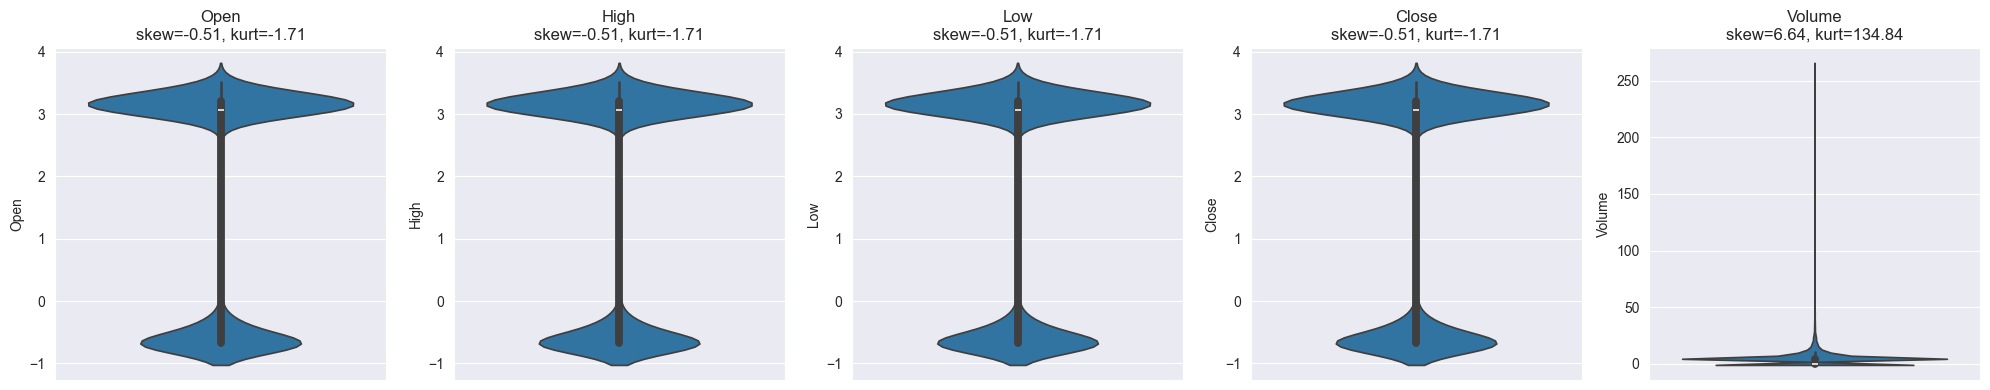

In [61]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(outliers_z_score.columns):
    skew_val = outliers_z_score_distribution.loc[outliers_z_score_distribution['Column'] == col, 'skew'].values[0]
    kurt_val = outliers_z_score_distribution.loc[outliers_z_score_distribution['Column'] == col, 'kurt'].values[0]

    sns.violinplot(y=outliers_z_score[col], ax=axes[i])
    axes[i].set_title(f'{col}\nskew={skew_val:.2f}, kurt={kurt_val:.2f}')
plt.tight_layout()
plt.show()

Ces outliers sont significatifs de période de comportement extrême du prix du Bitcoin (période de crash, bullrun, etc...).

Comme ces valeurs correspondent à des évènements bien réels, la meilleure stratégie à adopter est de les conserver.

## Calcul des quartiles et interprétation
Calculons désormais les quartiles, les écarts interquartiles et les bornes inférieurs et supérieurs de nos valeurs.

In [62]:
def identify_quartiles(df: DataFrame) -> DataFrame:
    """
    Calcule les quartiles et les bornes inférieures et supérieures pour chaque colonne d'un DataFrame.\n
    Q1: Premier quartile (25e percentile)\n
    Q3: Troisième quartile (75e percentile)\n
    IQR: Ecart interquartile (Q3 - Q1)\n
    Borne inférieure: Q1 - 1.5 × IQR (valeurs en dessous = outliers)\n
    Borne supérieure: Q3 + 1.5 × IQR (valeurs au-dessus = outliers)
    :param df: DataFrame contenant les données à analyser
    :type df: pandas.DataFrame
    :return: DataFrame contenant les quartiles et bornes pour chaque colonne
    :rtype: pandas.DataFrame
    """
    quartiles_list = []

    for series_name, series in df.items():
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        lower_fence = q1 - 1.5 * iqr
        upper_fence = q3 + 1.5 * iqr

        column_dict = {
            "Colonne": series_name,
            "Q1": q1,
            "Q3": q3,
            "IQR": iqr,
            "Borne inférieure": lower_fence,
            "Borne supérieure": upper_fence
        }
        quartiles_list.append(column_dict)

    df_quartiles = pd.DataFrame(quartiles_list)

    return df_quartiles

In [63]:
df_quartiles = identify_quartiles(df_bitcoin_modified)
df_quartiles

,Colonne,Q1,Q3,IQR,Borne inférieure,Borne supérieure
0,Open,443.010000,30680.000000,30236.990000,-44912.475000,76035.48500
1,High,443.230000,30691.000000,30247.770000,-44928.425000,76062.65500
2,Low,442.940000,30670.810000,30227.870000,-44898.865000,76012.61500
3,Close,443.010000,30681.000000,30237.990000,-44913.975000,76037.98500
4,Volume,0.019612,2.896763,2.877151,-4.296114,7.21249


Les colonnes Open, High, Low et Close présentent de très larges écarts interquartiles (`IQR`) d'environ 30230, ce qui signifie qu'environ 50% de nos données de prix se situent entre 443 et 30,680$. Cela montre une très forte volatilité du prix du Bitcoin sur la période mesurée.

Si on souhaitait utiliser l'IQR afin d'identifier les outliers, alors tout prix supérieur à environ 76,000$ serait considéré comme anormal, ce qui ne respecte pas la tendance globale du prix du Bitcoin:

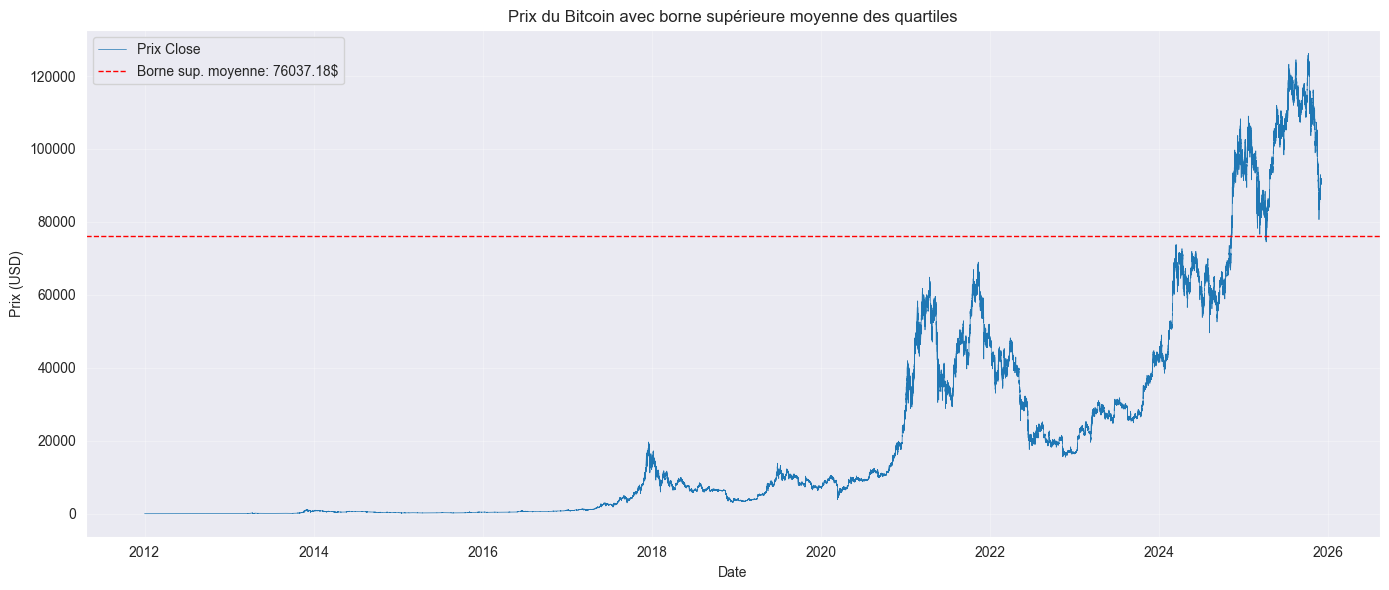

In [64]:
mean_upper_fence = df_quartiles.loc[df_quartiles['Colonne'].isin(['Open', 'High', 'Low', 'Close']), 'Borne supérieure'].mean()

plt.figure(figsize=(14, 6))
plt.plot(df_bitcoin_modified.index, df_bitcoin_modified['Close'], label='Prix Close', linewidth=0.5)
plt.axhline(y=mean_upper_fence, color='red', linestyle='--', linewidth=1, label=f'Borne sup. moyenne: {mean_upper_fence:.2f}$')
plt.xlabel('Date')
plt.ylabel('Prix (USD)')
plt.title('Prix du Bitcoin avec borne supérieure moyenne des quartiles')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Nous pouvons donc en déduire que l'utilisation de l'IQR n'est pas adaptée pour identifier les outliers / anomalies de prix du Bitcoin.

Quant au volume, une borne supérieure d'environ 7.21 et un IQR d'environ 2.88 semblent être pertinent pour identifier les anomalies de volume. Nous pouvons le vérifier à l'aide d'une visualisation:

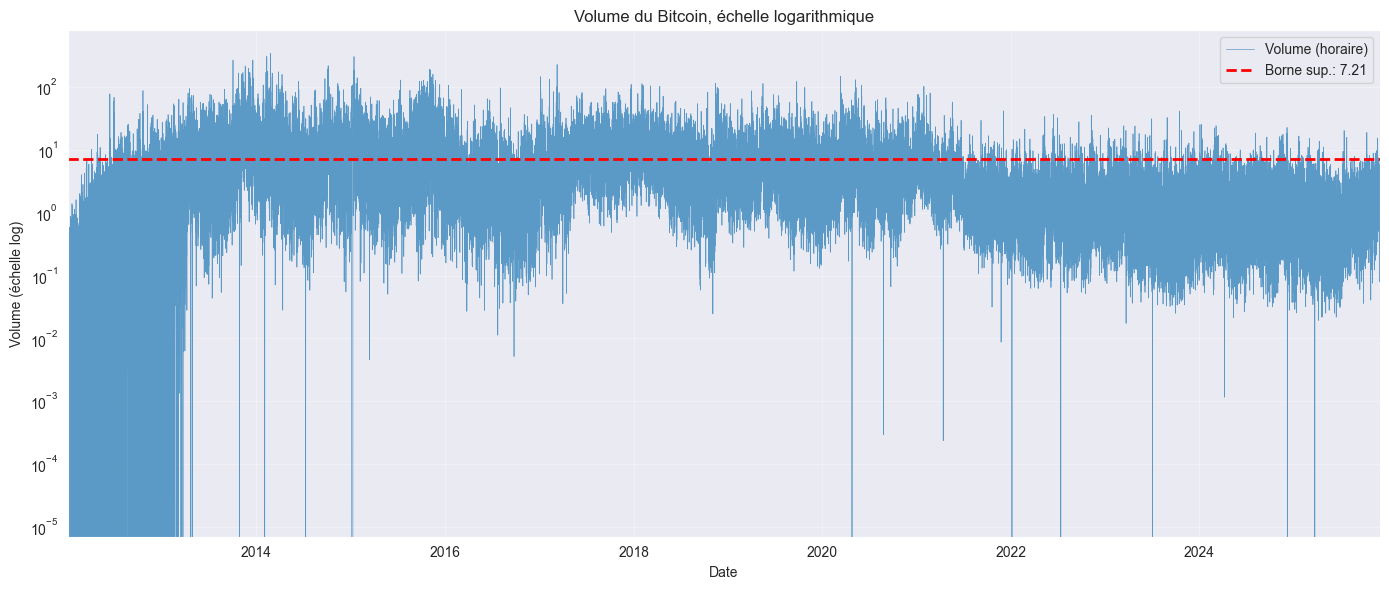

In [65]:
volume_upper_fence = df_quartiles.loc[df_quartiles['Colonne'] == 'Volume', 'Borne supérieure'].values[0]

# Nécessaire pour éviter de devoir tracer 7.3 millions de points
df_hourly_volume = df_bitcoin_modified['Volume'].resample('h').mean()

plt.figure(figsize=(14, 6))
plt.plot(df_hourly_volume.index, df_hourly_volume, label='Volume (horaire)', linewidth=0.5, alpha=0.7)
plt.axhline(y=volume_upper_fence, color='red', linestyle='--', linewidth=2, label=f'Borne sup.: {volume_upper_fence:.2f}')
plt.xlabel('Date')
plt.ylabel('Volume (échelle log)')
plt.yscale('log')
plt.title('Volume du Bitcoin, échelle logarithmique')
plt.xlim(df_hourly_volume.index.min(), df_hourly_volume.index.max())
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Sur le graphique ci-dessus, les valeurs au-dessus de la ligne rouge (représentant la borne supérieure du volume) peuvent être considérée comme des anomalies de volume.

# Feature Engineering
Maintenant que nous avons analysé en détail les distributions et statistiques de nos données, nous pouvons calculer de nouvelles variables intéressantes.

Commençons d'abord par standardiser nos colonnes initiales, en les convertissant en minuscules.

In [66]:
df_bitcoin_modified.columns = df_bitcoin_modified.columns.str.lower()
print(df_bitcoin_modified.columns)

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')


## `returns`, taux d'évolution du prix par rapport au prix précédent

In [67]:
df_bitcoin_modified['returns'] = df_bitcoin_modified['close'].pct_change()
df_bitcoin_modified['returns'].head()

Timestamp
2012-01-01 10:01:00    NaN
2012-01-01 10:02:00    0.0
2012-01-01 10:03:00    0.0
2012-01-01 10:04:00    0.0
2012-01-01 10:05:00    0.0
Freq: min, Name: returns, dtype: float64

La première valeur `returns` est un `NaN`, car il n'y a pas de valeur précédente. Nous pouvons transformer cette valeur en `0.0`.

In [68]:
df_bitcoin_modified['returns'] = df_bitcoin_modified['returns'].fillna(0.0)
df_bitcoin_modified['returns'].head()

Timestamp
2012-01-01 10:01:00    0.0
2012-01-01 10:02:00    0.0
2012-01-01 10:03:00    0.0
2012-01-01 10:04:00    0.0
2012-01-01 10:05:00    0.0
Freq: min, Name: returns, dtype: float64

## `volatility`, volatilité sur la dernière heure
La volatilité est calculée en fonction de l'écart-type des valeurs `returns` sur une fênetre roulante de 60 périodes, soit 60 minutes.

In [69]:
df_bitcoin_modified['volatility'] = df_bitcoin_modified['returns'].rolling(60).std()
df_bitcoin_modified['volatility'].iloc[54:65]

Timestamp
2012-01-01 10:55:00    NaN
2012-01-01 10:56:00    NaN
2012-01-01 10:57:00    NaN
2012-01-01 10:58:00    NaN
2012-01-01 10:59:00    NaN
2012-01-01 11:00:00    0.0
2012-01-01 11:01:00    0.0
2012-01-01 11:02:00    0.0
2012-01-01 11:03:00    0.0
2012-01-01 11:04:00    0.0
2012-01-01 11:05:00    0.0
Freq: min, Name: volatility, dtype: float64

Les 60 premières valeurs sont `NaN`, car le nombre de période temporelle nécessaire au calcul n'est pas encore atteint. Les données seront agrégées plus tard, ce qui résolvera tous problèmes éventuels liés à ces valeurs.

## `price_range`, intervalle entre le prix `high` et le prix `low`

In [70]:
df_bitcoin_modified['price_range'] = df_bitcoin_modified['high'] - df_bitcoin_modified['low']

# Echantillon aléatoire, avec seed
df_bitcoin_modified['price_range'].sample(n=5, random_state=42)

Timestamp
2018-09-19 15:30:00     1.39
2022-06-29 18:05:00    41.36
2023-12-29 15:34:00    21.00
2013-01-26 02:13:00     0.00
2025-04-12 02:11:00    28.00
Name: price_range, dtype: float64

## `close_ma_60`, moyenne mobile sur 60 période du prix `close`

In [72]:
df_bitcoin_modified['close_ma_60'] = df_bitcoin_modified['close'].rolling(60).mean()
df_bitcoin_modified['close_ma_60'].iloc[54:65]

Timestamp
2012-01-01 10:55:00     NaN
2012-01-01 10:56:00     NaN
2012-01-01 10:57:00     NaN
2012-01-01 10:58:00     NaN
2012-01-01 10:59:00     NaN
2012-01-01 11:00:00    4.58
2012-01-01 11:01:00    4.58
2012-01-01 11:02:00    4.58
2012-01-01 11:03:00    4.58
2012-01-01 11:04:00    4.58
2012-01-01 11:05:00    4.58
Freq: min, Name: close_ma_60, dtype: float64

Ici encore, les 60 premières valeurs sont `NaN`, car il n'y a pas assez de période pour les calculs. Une fois agrégées, ces valeurs disparaitront.

## `volume_ma_60`, moyenne mobile sur 60 période du volume

In [73]:
df_bitcoin_modified['volume_ma_60'] = df_bitcoin_modified['volume'].rolling(60).mean()
df_bitcoin_modified['volume_ma_60'].iloc[54:65]

Timestamp
2012-01-01 10:55:00    NaN
2012-01-01 10:56:00    NaN
2012-01-01 10:57:00    NaN
2012-01-01 10:58:00    NaN
2012-01-01 10:59:00    NaN
2012-01-01 11:00:00    0.0
2012-01-01 11:01:00    0.0
2012-01-01 11:02:00    0.0
2012-01-01 11:03:00    0.0
2012-01-01 11:04:00    0.0
2012-01-01 11:05:00    0.0
Freq: min, Name: volume_ma_60, dtype: float64

Idem pour cette nouvelle colonne.

In [74]:
df_bitcoin_modified['volume_ma_60'].sample(n=5, random_state=42)


Timestamp
2018-09-19 15:30:00    1.787186
2022-06-29 18:05:00    1.737815
2023-12-29 15:34:00    0.755241
2013-01-26 02:13:00    0.406477
2025-04-12 02:11:00    0.469258
Name: volume_ma_60, dtype: float64

## `volume_log`, afin de réduire la valeur `skew()` de `volume`
Comme vu précédement, la valeur `skew()` de la colonne volume était très importante:

In [75]:
df_bitcoin_stats.loc[df_bitcoin_stats['Column'] == 'Volume', 'skew']

4    27.801996
Name: skew, dtype: float64

Une échelle logarithmique permettera de grandement réduire cette valeur:

In [76]:
df_bitcoin_modified['volume_log'] = np.log(df_bitcoin_modified['volume'] + 1)
print(f"Valeur skew() de volume_log: {df_bitcoin_modified['volume_log'].skew()}")

Valeur skew() de volume_log: 1.5295488221706668


## Résumé des nouvelles colonnes

In [77]:
df_bitcoin_modified.columns

Index(['open', 'high', 'low', 'close', 'volume', 'returns', 'volatility',
       'price_range', 'close_ma_60', 'volume_ma_60', 'volume_log'],
      dtype='object')

# Export du DataFrame modifieé vers un nouveau fichier Parquet
Afin de gagner du temps pour de potentielles futures analyses ou pour une meilleure reproductibilité, nous pouvons maintenant exporter le DataFrame `df_bitcoin_modified` sous format Parquet, plus performant que CSV pour de grands jeux de données.

In [78]:
df_bitcoin_modified.to_parquet('data/clean/bitcoin_1min_clean.parquet', engine='fastparquet')
print(f"DataFrame exporté en Parquet ...")

DataFrame exporté en Parquet ...


# Agrégations temporelles
Afin de procéder à des agrégations temporelles dans les meilleures conditions, nous pouvons créer une fonction dédiée nous permettant de recalculer les Features de la section précédente et de manipuler les variables existantes en un ensemble cohérent.

In [86]:
def aggregate_ohlcv(df, freq, ma_windows):
    """
    Agrège correctement des données OHLCV.
    :param df: DataFrame avec colonnes open, high, low, close, volume
    :type df: pandas.DataFrame
    :param freq : fréquence ('h', 'D', 'ME', 'W', etc.) d'agrégation voulue
    :type freq: str
    :param ma_windows: fenêtres pour moyennes mobiles (ex: [7, 30, 90] pour 7j, 30j ou 90j)
    :type ma_windows: list
    :return: DataFrame agrégé avec features dérivées
    :rtype: pandas.DataFrame
    """

    df_agg = df.resample(freq).agg({
        # open doit correspondre à la première valeur open de la fréquence d'agrégation voulue
        'open': 'first',

        # high doit être la plus grande valeur high sur la même période
        'high': 'max',

        # low est la valeur low la plus petite sur la même période
        'low': 'min',

        # close correspond ici à la dernière valeur enregistrée pour close
        'close': 'last',

        # les volumes de la période d'agrégation doivent être additionnés
        'volume': 'sum'
    })

    # Features Engineering
    df_agg['returns'] = df_agg['close'].pct_change()
    df_agg['price_range'] = df_agg['high'] - df_agg['low']

    for window in ma_windows:
        df_agg[f'volatility_{window}'] = df_agg['returns'].rolling(window).std()
        df_agg[f'close_ma_{window}'] = df_agg['close'].rolling(window).mean()
        df_agg[f'volume_ma_{window}'] = df_agg['volume'].rolling(window).mean()


    df_agg['volume_log'] = np.log(df_agg['volume'] + 1)

    return df_agg

Cette fonction nous permet de définir une liste de périodes temporelles à utiliser en temps que fenêtre roulante, et nous pouvons calculer les mêmes valeurs dérivées que pour notre DataFrame `df_bitcoin_modified` mais sur des périodes agrégées.

In [92]:
# Série agrégée 1 heure, avec fenêtre de 24h et d'une semaine
df_bitcoin_1_hour = aggregate_ohlcv(df_bitcoin_modified, 'h', ma_windows=[24, 168])
print(f"DataFrame horaire: {len(df_bitcoin_1_hour):,} lignes")

# Série agrégée 1 jour, avec fenêtre d'une semaine, un mois et trois mois
df_bitcoin_1_day = aggregate_ohlcv(df_bitcoin_modified, 'D', ma_windows=[7, 30, 90])
print(f"DataFrame journalier: {len(df_bitcoin_1_day):,} lignes")

# Série agrégée 1 mois, avec fenêtre de trois mois et d'un an
df_bitcoin_1_month = aggregate_ohlcv(df_bitcoin_modified, 'ME', ma_windows=[3, 12])
print(f"DataFrame mensuel: {len(df_bitcoin_1_month):,} lignes")

DataFrame horaire: 121,982 lignes
DataFrame journalier: 5,083 lignes
DataFrame mensuel: 167 lignes


Statistiques descriptives pour l'agrégation 1 heure:

In [93]:
df_bitcoin_1_hour.describe()

,open,high,low,close,volume,returns,price_range,volatility_24,close_ma_24,volume_ma_24,volatility_168,close_ma_168,volume_ma_168,volume_log
count,121982.000000,121982.000000,121982.000000,121982.000000,121982.000000,121981.000000,121982.000000,121958.000000,121959.000000,121959.000000,121814.000000,121815.000000,121815.000000,121982.000000
mean,21259.367722,21344.648247,21169.009247,21260.062743,307.663536,0.000129,175.639000,0.007040,21255.465331,307.716716,0.007686,21227.148496,308.034942,4.777105
std,29928.876847,30027.968999,29825.220088,29929.339342,564.496113,0.009744,310.697867,0.006812,29920.972922,375.354944,0.006000,29871.559208,303.608492,1.569877
min,4.140000,4.170000,3.800000,4.140000,0.000000,-0.293396,0.000000,0.000000,4.280000,0.000000,0.001392,4.491310,1.578302,0.000000
25%,442.980000,444.855000,441.000000,442.990000,48.491282,-0.002450,3.162500,0.003480,443.526667,81.451445,0.004306,444.585149,86.983441,3.901797
50%,7284.870000,7319.375000,7244.010000,7285.755000,136.969641,0.000000,47.060000,0.005355,7273.851250,187.303084,0.006129,7259.229702,217.015064,4.927034
75%,30689.000000,30803.250000,30562.517500,30689.075000,341.552485,0.002745,225.715000,0.008332,30622.090833,397.780620,0.008823,30530.785714,421.055944,5.836425
max,126094.000000,126272.000000,125333.000000,126111.000000,20551.251040,0.348236,8607.430000,0.147103,124785.541667,5810.430172,0.085007,122815.357143,2336.398281,9.930726


Statistiques descriptives pour l'agrégation 1 jour:

In [94]:
df_bitcoin_1_day.describe()

,open,high,low,close,volume,returns,price_range,volatility_7,close_ma_7,volume_ma_7,volatility_30,close_ma_30,volume_ma_30,volatility_90,close_ma_90,volume_ma_90,volume_log
count,5083.000000,5083.000000,5083.000000,5083.000000,5083.000000,5082.000000,5083.000000,5076.000000,5077.000000,5077.000000,5053.000000,5054.000000,5054.000000,4993.000000,4994.000000,4994.000000,5083.000000
mean,21247.355019,21707.366016,20764.113618,21265.053309,7383.319582,0.002790,943.252398,0.032221,21236.652315,7391.078534,0.034625,21122.485596,7416.785117,0.036236,20723.150650,7491.064257,8.321464
std,29924.593122,30457.725352,29355.310699,29938.758567,8997.009623,0.040771,1462.466341,0.024947,29886.869013,7285.484109,0.020837,29682.079912,6451.102848,0.017615,28844.640446,5895.867073,1.215628
min,4.380000,4.380000,3.800000,4.380000,0.000000,-0.538385,0.000000,0.002380,4.561429,37.879241,0.007466,4.855000,63.584503,0.012570,4.935778,174.105653,0.000000
25%,443.330000,451.655000,430.950000,443.380000,1973.387718,-0.012327,16.040000,0.017250,444.424286,2087.412921,0.022431,451.130000,2231.386946,0.024938,481.417028,2284.020028,7.588013
50%,7294.890000,7469.000000,7102.160000,7294.000000,4453.468493,0.001557,292.090000,0.026373,7272.294286,5202.232021,0.029445,7292.534667,5681.839373,0.032082,7853.669167,6614.379483,8.401663
75%,30633.310000,31479.000000,30000.500000,30662.500000,9537.482413,0.017715,1308.500000,0.038710,30578.285714,10118.070648,0.040649,30408.325000,10722.844043,0.043600,29736.925139,10715.019495,9.163090
max,124728.000000,126272.000000,123148.000000,124728.000000,127286.486533,0.358107,13535.630000,0.343084,122775.857143,55865.455029,0.195243,117509.866667,36401.817985,0.124824,115764.988889,28451.117669,11.754203


Statistiques descriptives pour l'agrégation 1 mois:

In [95]:
df_bitcoin_1_month.describe()

,open,high,low,close,volume,returns,price_range,volatility_3,close_ma_3,volume_ma_3,volatility_12,close_ma_12,volume_ma_12,volume_log
count,167.000000,167.000000,167.000000,167.000000,167.000000,166.000000,167.000000,164.000000,165.000000,165.000000,155.000000,156.000000,156.000000,167.000000
mean,20832.147784,24047.002695,18348.518563,21373.068802,224727.026562,0.102631,5698.484132,0.234888,21045.602788,226935.598659,0.302919,19218.364722,237678.494796,11.905750
std,29402.868808,33003.509763,26521.198633,29845.008187,195807.203666,0.426222,7489.158694,0.337668,29161.996979,179875.413362,0.307050,25125.091531,149415.303912,1.015096
min,4.580000,5.150000,3.800000,4.920000,2012.253436,-0.402049,0.290000,0.007275,4.970000,5274.496266,0.104651,8.310833,47279.589796,7.607507
25%,440.565000,525.000000,373.600000,448.290000,69882.998356,-0.084708,126.700000,0.114645,486.306667,68311.816191,0.158196,492.429167,71152.021907,11.154590
50%,7145.050000,9219.130000,6072.000000,7484.430000,164360.140734,0.047894,2150.210000,0.173784,7971.106667,196309.850815,0.206674,7353.924583,245149.902827,12.009821
75%,30987.305000,36827.500000,27357.500000,32049.110000,325556.892384,0.197649,10053.445000,0.239885,29666.640000,318436.334202,0.257021,30521.195625,363288.378705,12.693256
max,115749.000000,126272.000000,107389.000000,115750.000000,965837.682683,4.448562,33002.000000,2.648441,112694.666667,848095.803744,1.351075,101061.416667,540462.509128,13.780752


# Analyse des tendances et volatilité
## Visualisation de l’évolution du prix dans le temps (courbe Close).

In [ ]:
print(df_bitcoin_1_hour.columns)

In [ ]:
df_bitcoin_1_hour[('Close', 'mean')].plot()

# Identification des périodes de Bull Run et de Crash

In [ ]:
class BitcoinTrendDetector:
    """
    Analyse les données de prix du Bitcoin pour identifier les tendances du marché, telles que les crashs 
    et les bull runs, en fonction de seuils et de durées prédéfinis.

    :ivar df: DataFrame contenant le jeu de données de prix du Bitcoin
    :type df: pandas.DataFrame
    :ivar price_col: Series contenant la colonne de prix du DataFrame
    :type price_col: pandas.Series
    :ivar regimes: DataFrame résumant les périodes de tendance identifiées, incluant les dates de début et de fin, 
        la durée et le rendement
    :type regimes: pandas.DataFrame
    """

    def __init__(self, df, price_col):
        """
        Initialise l'objet
        
        :param df: DataFrame contenant les données de prix du Bitcoin
        :type df: pandas.DataFrame
        :param price_col: Colonne les prix à analyser
        :type price_col: pandas.Series
        """
        self.df = df.copy()
        self.price_col = price_col
        self.regimes = None

    def identify_trends(
            self,
            min_crash_timeframe: str,
            min_bullrun_timeframe: str,
            crash_threshold: float,
            bullrun_threshold: float,
            window: str):
        """
        Identifie les tendances du marché (crash, bullrun, neutral) en fonction de seuils et durées spécifiés.
        
        :param min_crash_timeframe: Durée minimale pour qu'un crash soit considéré valide ('7D' pour 7 jours)
        :type min_crash_timeframe: str
        :param min_bullrun_timeframe: Durée minimale pour qu'un bull run soit considéré valide ('30D' pour 30 jours)
        :type min_bullrun_timeframe: str
        :param crash_threshold: Seuil de perte pour identifier un crash (-0.30 pour -30%)
        :type crash_threshold: float
        :param bullrun_threshold: Seuil de gain depuis le plus bas pour identifier un bull run (1.0 pour +100%)
        :type bullrun_threshold: float
        :param window: Fenêtre pour calculer les maximums et minimums roulants ('180D' pour 180 jours)
        :type window: str
        :return: DataFrame contenant les périodes de tendance identifiées avec leurs caractéristiques
        :rtype: pandas.DataFrame
        """
        df = self.df.copy()
        price_col = self.price_col.copy()

        # Trouve le maximum local sur la periode etudiee
        rolling_max = price_col.rolling(window=window, min_periods=1).max()
        # Calcule le drawdown (perte) depuis le maximum local
        drawdown = (price_col - rolling_max) / rolling_max

        # Trouve le minimum local sur la periode etudiee
        rolling_min = price_col.rolling(window=window, min_periods=1).min()
        # Calcule le gain depuis le minimum local
        gain_from_low = (price_col - rolling_min) / rolling_min

        # Nouvelle serie initialisee en trend 'neutral'
        trend = pd.Series('neutral', index=df.index)

        # On identifie les periodes de perte superieures a notre seuil => crash
        crash_mask = drawdown <= crash_threshold
        trend[crash_mask] = 'crash'

        # On identifie les periodes de gain superieures a notre seuil => bull run
        bull_mask = gain_from_low >= bullrun_threshold
        trend[bull_mask] = 'bullrun'

        # Applique le filtre de durée minimale pour les crashs et bull runs
        trend = self._apply_duration_filter(trend, 'crash', min_crash_timeframe)
        trend = self._apply_duration_filter(trend, 'bullrun', min_bullrun_timeframe)

        # Ajoute les colonnes de tendance et métriques au DataFrame
        df['trend'] = trend
        df['drawdown'] = drawdown
        df['gain_from_low'] = gain_from_low

        self.df = df
        self.regimes = self._extract_trend_periods()

        return self.regimes

    @staticmethod
    def _apply_duration_filter(trend_series, trend_type, min_duration):
        """
        Filtre les périodes de tendance en fonction d'une durée minimale.
        
        :param trend_series: Série contenant les tendances identifiées
        :type trend_series: pandas.Series
        :param trend_type: Type de tendance à filtrer ('crash' ou 'bullrun')
        :type trend_type: str
        :param min_duration: Durée minimale requise ('7D')
        :type min_duration: str
        :return: Série de tendances filtrée
        :rtype: pandas.Series
        """
        result = trend_series.copy()
        min_delta = pd.Timedelta(min_duration)

        # Identifie les périodes correspondant au type de tendance spécifié
        is_trend = trend_series == trend_type
        trend_changes = is_trend.astype(int).diff().fillna(0)

        # Trouve les points de début et de fin de chaque période
        starts = trend_series.index[trend_changes == 1]
        ends = trend_series.index[trend_changes == -1]

        # Vérifie la durée de chaque période et filtre celles trop courtes
        for start, end in zip(starts, ends):
            duration = end - start
            if duration < min_delta:
                result.loc[start:end] = 'neutral'

        return result

    def _extract_trend_periods(self):
        """
        Extrait les périodes de tendance du DataFrame.

        :return: DataFrame contenant les informations sur chaque période de tendance (type, dates, durée, 
                 prix de début/fin, rendement)
        :rtype: pandas.DataFrame
        """
        trend = self.df['trend']
        trend_changes = (trend != trend.shift()).astype(int)
        price_col = self.price_col.copy()

        periods = []
        current_trend = trend.iloc[0]
        start_date = trend.index[0]

        # Parcourt toutes les données pour identifier les changements de tendance
        for i in range(1, len(trend)):
            if trend_changes.iloc[i]:
                # Si la tendance précédente n'était pas neutre, on l'enregistre
                if current_trend != 'neutral':
                    periods.append({
                        'trend': current_trend,
                        'start': start_date,
                        'end': trend.index[i - 1],
                        'duration': trend.index[i - 1] - start_date,
                        'start_price': price_col.loc[start_date],
                        'end_price': price_col.loc[trend.index[i - 1]]
                    })
                current_trend = trend.iloc[i]
                start_date = trend.index[i]

        # Traite la dernière période si elle n'est pas neutre
        if current_trend != 'neutral':
            periods.append({
                'trend': current_trend,
                'start': start_date,
                'end': trend.index[-1],
                'duration': trend.index[-1] - start_date,
                'start_price': price_col.loc[start_date],
                'end_price': price_col.iloc[-1]
            })

        periods_df = pd.DataFrame(periods)
        # Calcule le rendement en pourcentage pour chaque période
        if len(periods_df) > 0:
            periods_df['return'] = (periods_df['end_price'] / periods_df['start_price'] - 1) * 100

        return periods_df


In [ ]:
detector = BitcoinTrendDetector(df_bitcoin_1_day, price_col=df_bitcoin_1_day[('Close', 'mean')])
regimes = detector.identify_trends(
    min_crash_timeframe='30D',
    min_bullrun_timeframe='30D',
    crash_threshold=-0.30,
    bullrun_threshold=1.0,
    window='180D'
)

In [ ]:
regimes

Maintenant que nous avons identifier nos périodes de Bull run et de Crash, nous pouvons les tracer (avec une échelle de prix logarithmique pour une meilleure clartée)

In [ ]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(detector.df.index, detector.price_col, color='black', linewidth=1.5, label='Prix du Bitcoin')

for _, period in detector.regimes.iterrows():
    if period['trend'] == 'bullrun':
        ax.axvspan(period['start'], period['end'], alpha=0.3, color='green', label='Bullrun')
    elif period['trend'] == 'crash':
        ax.axvspan(period['start'], period['end'], alpha=0.3, color='red', label='Crash')

ax.set_yscale('log')
ax.set_xlabel('Date', fontweight='bold')
ax.set_ylabel('Prix (USD)', fontweight='bold')
ax.set_title('Périodes de Bull Run et de Crash du Bitcoin', fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

# Analyse de la volatilité et variation relative
Nous allons analyser la volatilité pour les agrégations temporelles `df_bitcoin_1_day` et `df_bitcoin_1_hour`
Calcul de la volatilé en utilisant un écart-type glissant (sur 24h et 30 jours respectivement)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

df_bitcoin_1_hour['returns'] = df_bitcoin_1_hour[('Close', 'mean')].pct_change(fill_method=None)
df_bitcoin_1_hour['volatility_24h'] = df_bitcoin_1_hour['returns'].rolling(window=24).std()
ax1.plot(df_bitcoin_1_hour.index, df_bitcoin_1_hour['volatility_24h'],color='cyan', label='Volatilité (24h)')
ax1.set_title('Volatilité court terme (données horaires)')
ax1.legend()
ax1.grid(True, alpha=0.3)

df_bitcoin_1_day['returns'] = df_bitcoin_1_day[('Close', 'mean')].pct_change(fill_method=None)
df_bitcoin_1_day['volatility_30d'] = df_bitcoin_1_day['returns'].rolling(window=30).std()
ax2.plot(df_bitcoin_1_day.index, df_bitcoin_1_day['volatility_30d'], color='red', label='Volatilité (30j)')
ax2.set_title('Volatilité long terme (données journalières)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

ax1.plot(df_bitcoin_1_hour.index, df_bitcoin_1_hour['returns'] * 100, color='purple', label='Variation relative horaire (%)')
ax1.set_title('Rendement court terme (données horaires)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.plot(df_bitcoin_1_day.index, df_bitcoin_1_day['returns'] * 100, color='orange', label='Variation relative journalière (%)')
ax2.set_title('Volatilité long terme (données journalières)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Relation entre prix et volume

In [ ]:
df_bitcoin_1_day['returns_abs'] = df_bitcoin_1_day['returns'].abs()
correlation_movement = df_bitcoin_1_day[('Volume', 'mean')].corr(df_bitcoin_1_day['returns_abs'])

print(f"Corrélation volume-prix : {df_bitcoin_1_day[('Volume', 'mean')].corr(df_bitcoin_1_day[('Close', 'mean')]):.3f}")
print(f"Corrélation volume-mouvement : {correlation_movement:.3f}")

On remarque une plus forte corrélation entre le volume d'échange du Bitcoin et les mouvement de prix.

# Heatmap de corrélation entre volume d'échange et heure / jour de la semaine

In [ ]:
import plotly.express as px

df_bitcoin_heatmap = df_bitcoin_raw.copy()

df_bitcoin_heatmap['hour'] = df_bitcoin_heatmap.index.hour
df_bitcoin_heatmap['day_of_week'] = df_bitcoin_heatmap.index.day_name()

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

pivot_volume = df_bitcoin_heatmap.pivot_table(
    values='Volume',
    index='day_of_week',
    columns='hour',
    aggfunc='mean'
)

pivot_volume = pivot_volume.reindex(days_order)

fig = px.imshow(pivot_volume,
                labels=dict(x="Heure du jour", y="Jour de la semaine", color="Volume moyen d\'échange"),
                x=pivot_volume.columns,
                y=pivot_volume.index,
                aspect="auto",
                title="Volume d\'échange moyen du Bitcoin par heure et jour de la semaine")

fig.update_xaxes(side="bottom")
fig.update_layout(height=500, width=1200)
fig.show()


# Synthèse et pistes d'optimisation
float64 -> float32 pour la mémoire

In [ ]:
#df_bitcoin_modified[df_bitcoin_modified.select_dtypes(np.float64).columns] = df_bitcoin_modified.select_dtypes(np.float64).astype(np.float32)